This notebook continued off of rough_rag, and attempts to use RAG to update the user's inputted lyrics to align better with an inputted feeling or semantic. The model uses a combination of target lyric embeddings and their semantic query embedding to find similar semantic songs in our dataset. We evalutate our method in the end.

### Downloading the model first

In [46]:
import os, certifi
os.environ["SSL_CERT_FILE"] = certifi.where()
os.environ["REQUESTS_CA_BUNDLE"] = certifi.where()

In [47]:
from sentence_transformers import SentenceTransformer
import tqdm as tqdm

model = SentenceTransformer("sentence-transformers/distiluse-base-multilingual-cased-v2")
print("Model loaded")

Model loaded


### Reading in data and making df

In [48]:
import numpy as np
import pandas as pd
from typing import List, Dict, Any

df1 = pd.read_parquet("lyric_embeddings/librosa_shard_0.parquet")
df2 = pd.read_parquet("lyric_embeddings/librosa_shard_1.parquet")
df3 = pd.read_parquet("lyric_embeddings/librosa_shard_2.parquet")
df4 = pd.read_parquet("lyric_embeddings/librosa_shard_3.parquet")
df5 = pd.read_parquet("lyric_embeddings/librosa_shard_4.parquet")

df = pd.concat([df1, df2, df3, df4, df5])

### REAL embedding functions

In [49]:
import faiss

emb_list = [np.asarray(x, dtype="float32") for x in df["lyrics_embedding"].values]
emb_matrix = np.stack(emb_list, axis=0)
dimension = emb_matrix.shape[1]   # e.g., 768
index = faiss.IndexFlatL2(dimension)

# Add embeddings to the index
index.add(emb_matrix.astype("float32"))

print("FAISS index built with", index.ntotal, "vectors.")

def retrieve_similar_songs(query_embedding: np.ndarray, k: int = 5) -> List[Dict[str, Any]]:
    # Ensure query is 2D array (1, 384) for FAISS
    query_vector = np.array([query_embedding]).astype('float32')

    # 1. Search the index
    # Note: We search the 'index' object we created in the previous cell
    D, I = index.search(query_vector, k)

    neighbors = []
    # I[0] contains the IDs, D[0] contains the distances
    for idx, dist in zip(I[0], D[0]):
        if idx != -1:
            neighbors.append({
                "index": int(idx),
                "similarity": float(dist) # In L2, lower is better.
            })

    return neighbors


FAISS index built with 20740 vectors.


In [50]:
import re
import unicodedata

# ---------- Cleaning helper for queries ----------

def clean_lyrics_for_query(text: str) -> str:
    """
    Simple lyric cleaner for user queries.

    • Lowercases text
    • Removes [chorus], [verse 1], etc.
    • Flattens newlines / \n into spaces
    • Strips things like (prod. xxx), (remix)
    • Drops repeat markers like x2, x3
    • Keeps letters (any language), digits, spaces, apostrophes
    """

    if not isinstance(text, str):
        return ""

    text = text.lower()

    # remove headers like [chorus], [verse 1], etc.
    text = re.sub(r"\[.*?\]", " ", text)

    # handle real and escaped newlines
    text = text.replace("\\n", " ").replace("\n", " ")

    # remove (prod. ...), (remix ...)
    text = re.sub(r"\(.*?prod.*?\)", " ", text)
    text = re.sub(r"\(.*?remix.*?\)", " ", text)

    # remove x2, x3, etc.
    text = re.sub(r"\bx\d+\b", " ", text)

    # keep letters (any language), numbers, spaces, apostrophes
    chars = []
    for ch in text:
        cat = unicodedata.category(ch)
        if cat.startswith("L") or cat.startswith("N") or ch in [" ", "'", "’"]:
            chars.append(ch)

    text = "".join(chars)

    # collapse multiple spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text


# ---------- REAL embedding function ----------

def embed_lyrics(text: str) -> np.ndarray:
    cleaned = clean_lyrics_for_query(text)

    # Encode returns a list of vectors when input is a list
    emb = model.encode(
        [cleaned],                    # IMPORTANT: wrap in list
        convert_to_numpy=True,
        normalize_embeddings=True
    )

    # emb has shape (1, D) → extract row 0
    vec = emb[0]

    # Ensure float32 1D
    vec = np.asarray(vec, dtype="float32").reshape(-1)

    return vec



In [51]:
audio_feature_cols = df.columns[df.columns.get_loc("duration") : df.columns.get_loc("tonnetz_6") + 1].tolist()
df.head()

,song_id,title,artist,query_title,query_artist,track_genre,popularity,lyrics,preview_url,track_id,...,spectral_contrast_6,spectral_contrast_7,tonnetz_1,tonnetz_2,tonnetz_3,tonnetz_4,tonnetz_5,tonnetz_6,lyrics_clean,lyrics_embedding
0,4845,State of Mind,Scooter,state of mind,scooter,happy,24.0,The world seems not the same...\n\nIntroducing...,https://audio-ssl.itunes.apple.com/itunes-asse...,1692327616,...,18.328021,39.053367,0.197966,-0.116721,0.142559,-0.069539,-0.044986,-0.047523,the world seems not the same introducing twist...,"[0.07519827783107758, -0.023364899680018425, -..."
1,462,Reptilia,The Strokes,reptilia,the strokes,alt-rock,75.0,[Verse 1]\nHe seemed impressed by the way you ...,https://audio-ssl.itunes.apple.com/itunes-asse...,302987569,...,17.382681,39.012014,0.078138,-0.077754,0.063345,0.036541,-0.011976,-0.014041,he seemed impressed by the way you came in tel...,"[-0.08670999109745026, -0.025700576603412628, ..."
2,16017,None Of My Business,Cher Lloyd,none of my business,cher lloyd,electro,64.0,"[Chorus]\nDamn, I heard that you and her been ...",https://audio-ssl.itunes.apple.com/itunes-asse...,1438630505,...,18.248683,39.966514,0.013912,0.172900,-0.092766,-0.056323,-0.004173,-0.014388,damn i heard that you and her been having prob...,"[0.01792941242456436, 0.001567921251989901, 0...."
3,9478,Trouble Sleeping,The Perishers,trouble sleeping,the perishers,acoustic,48.0,I'm having trouble sleeping\nYou're jumping in...,https://audio-ssl.itunes.apple.com/itunes-asse...,89335271,...,16.969837,28.947224,-0.118755,0.195544,0.025169,-0.130705,0.024176,0.005865,i'm having trouble sleeping you're jumping in ...,"[0.012034112587571144, -0.0008498362149111927,..."
4,2822,Shot in the Dark,Ozzy Osbourne,shot in the dark,ozzy osbourne,hard-rock,65.0,[Verse 1]\nOut on the streets I'm stalking the...,https://audio-ssl.itunes.apple.com/itunes-asse...,158711416,...,17.184653,35.540522,-0.113671,0.023209,-0.029743,-0.051142,0.003486,-0.011837,out on the streets i'm stalking the night i ca...,"[-0.05440174415707588, 0.0212415661662817, -0...."


In [52]:
def construct_feature_vector(
    target_embedding: np.ndarray,
    neighbors: List[Dict[str, Any]],
    audio_feature_cols: List[str],
    k: int = 3
) -> np.ndarray:

    vec = []

    target_embedding = np.asarray(target_embedding, dtype="float32").reshape(-1)
    EMB_DIM = target_embedding.shape[0]
    vec.extend(target_embedding.tolist())

    AUDIO_DIM = len(audio_feature_cols)
    NEIGHBOR_BLOCK = EMB_DIM + 2 + AUDIO_DIM  # emb + similarity + popularity + audio to ensure they all the same size

    for i in range(k):
        if i < len(neighbors):
            nb = neighbors[i]

            # neighbor embedding
            nb_emb = df.iloc[nb["index"]]["lyrics_embedding"]
            nb_emb = np.asarray(nb_emb, dtype="float32").reshape(-1)

            # fill nans if neighbros dont exist
            if nb_emb.shape[0] != EMB_DIM:
                fixed_emb = np.full(EMB_DIM, np.nan, dtype="float32")
                fixed_emb[:min(EMB_DIM, len(nb_emb))] = nb_emb[:EMB_DIM]
                nb_emb = fixed_emb

            vec.extend(nb_emb.tolist())

            # similarity
            sim = nb.get("similarity", np.nan)
            vec.append(float(sim))

            # popularity
            vec.append(float(nb["popularity"]))

            # audio features
            af = nb["audio_features"]
            for col in audio_feature_cols:
                val = af.get(col, np.nan)
                if isinstance(val, (float, int, np.floating)):
                    vec.append(float(val))
                else:
                    vec.append(np.nan)

        else:
            vec.extend([np.nan] * NEIGHBOR_BLOCK)

    return np.asarray(vec, dtype="float32")


In [53]:
def get_top_k_neighbors(df, query_embedding, k=5):
    raw_neighbors = retrieve_similar_songs(query_embedding, k=k)
    neighbors = []

    for n in raw_neighbors:
        idx = n["index"]
        row = df.iloc[idx]

        audio_features = {}

        for col in audio_feature_cols:
            val = row[col]

            # keep if scalar
            if np.isscalar(val):
                audio_features[col] = float(val)
            
            # flatten if array
            elif isinstance(val, np.ndarray):
                val = val.flatten()
                for j, v in enumerate(val):
                    audio_features[f"{col}_{j}"] = float(v)
            
            # flatten if list
            elif isinstance(val, list):
                for j, v in enumerate(val):
                    audio_features[f"{col}_{j}"] = float(v)

            else:
                try:
                    audio_features[col] = float(val)
                except Exception:
                    audio_features[col] = None

        neighbor_data = {
            "index": idx,
            "song_id": row["song_id"],
            "title": row["title"],
            "artist": row["artist"],
            "similarity": n.get("similarity", None),
            "popularity": float(row["popularity"]),
            "lyrics_snippet": row["lyrics"][:400].replace("\n", " ") + "...",
            "audio_features": audio_features
        }
        
        neighbors.append(neighbor_data)

    return neighbors


In [54]:
def retrieve_style_conditioned_neighbors(
    lyric_embedding: np.ndarray,
    style_request: str,
    df: pd.DataFrame,
    k: int = 5,
    weight_lyric: float = 0.7,
    weight_style: float = 0.3,
):
    # embed style descriptor (e.g., "romantic yearning")
    style_vec = embed_lyrics(style_request)

    # weighted combination
    combined = weight_lyric * lyric_embedding + weight_style * style_vec

    # retrieve neighbors using FAISS
    raw_neighbors = retrieve_similar_songs(combined, k=k)
    return raw_neighbors


In [55]:
def get_top_k_style_neighbors(df, lyric_emb, style_request, k=5):
    raw = retrieve_style_conditioned_neighbors(
        lyric_embedding=lyric_emb,
        style_request=style_request,
        df=df,
        k=k
    )
    # convert raw neighbors → full neighbor dicts
    neighbors = []
    for n in raw:
        idx = n["index"]
        row = df.iloc[idx]

        audio_features = {}
        for col in audio_feature_cols:
            val = row[col]
            if np.isscalar(val):
                audio_features[col] = float(val)
            elif isinstance(val, (list, np.ndarray)):
                for j, v in enumerate(val):
                    audio_features[f"{col}_{j}"] = float(v)
            else:
                audio_features[col] = None

        neighbors.append({
            "index": idx,
            "song_id": row["song_id"],
            "title": row["title"],
            "artist": row["artist"],
            "similarity": n["similarity"],
            "lyrics_snippet": row["lyrics"][:400].replace("\n"," ") + "...",
            "audio_features": audio_features
        })
    return neighbors


In [56]:
def build_rag_prompt_for_lyric_rewriting(
    user_lyric: str,
    style_request: str,
    neighbors: List[Dict[str, Any]]
):
    lines = []

    lines.append("You are an expert lyricist and stylist.")
    lines.append("Rewrite the user's lyric according to the requested style.")
    lines.append("")
    lines.append("CRITICAL REQUIREMENTS:")
    lines.append(" - Keep the core meaning unless user asks otherwise.")
    lines.append(" - Make stylistic changes grounded in retrieved songs.")
    lines.append(" - Use lyrical themes, tone, metaphor, and imagery from neighbors.")
    lines.append(" - Do NOT output disclaimers or analysis outside the JSON.")
    lines.append("")
    lines.append("OUTPUT FORMAT:")
    lines.append("{")
    lines.append('  "rewritten_lyric": "<new lyric>",')
    lines.append('  "explanation": "<brief justification referring to neighbors>"')
    lines.append("}")
    lines.append("")
    lines.append("------------------------------------------------------------")
    lines.append(f"USER LYRIC:\n{user_lyric}")
    lines.append("------------------------------------------------------------")
    lines.append(f"STYLE REQUEST: {style_request}")
    lines.append("------------------------------------------------------------")
    lines.append("STYLE-MATCHING NEIGHBOR SONGS:")

    for i, nb in enumerate(neighbors, start=1):
        lines.append(f"\nNeighbor #{i}:")
        lines.append(f"  title: {nb['title']}")
        lines.append(f"  artist: {nb['artist']}")
        lines.append(f"  similarity_score: {nb['similarity']:.4f}")
        lines.append(f"  lyrics_snippet: {nb['lyrics_snippet']}")
    
    lines.append("------------------------------------------------------------")
    lines.append("Using ONLY the above information, rewrite the lyric.")
    
    return "\n".join(lines)


In [57]:
def parse_json_from_llm(raw_text: str):
    raw = raw_text.replace("```json","").replace("```","").strip()

    try:
        return json.loads(raw)
    except:
        pass

    matches = re.findall(r"\{(?:[^{}]|(?:\{[^{}]*\}))*\}", raw, flags=re.DOTALL)
    for m in matches:
        try:
            return json.loads(m)
        except:
            pass

    print("Could not parse JSON — returning raw text.")
    return {"rewritten_lyric": None, "explanation": raw}


In [58]:
import os
import re
import json
from openai import OpenAI
from dotenv import load_dotenv

load_dotenv()
client = OpenAI()

def call_llm_for_rewrite(prompt: str):
    response = client.responses.create(
        model="gpt-4o",
        input=prompt,
        temperature=0.4,
        max_output_tokens=600
    )
    raw_text = response.output[0].content[0].text
    return parse_json_from_llm(raw_text)





In [59]:
def rag_lyric_style_rewrite_system(
    df: pd.DataFrame,
    user_lyric: str,
    style_request: str,
    k_neighbors: int = 5
):
    # 1. Embed lyric
    lyric_emb = embed_lyrics(user_lyric)

    # 2. Retrieve style-aware neighbors
    neighbors = get_top_k_style_neighbors(
        df=df,
        lyric_emb=lyric_emb,
        style_request=style_request,
        k=k_neighbors
    )

    # 3. Build rewriting prompt
    prompt = build_rag_prompt_for_lyric_rewriting(
        user_lyric=user_lyric,
        style_request=style_request,
        neighbors=neighbors
    )

    # 4. Call LLM
    llm_output = call_llm_for_rewrite(prompt)

    return {
        "rewritten_lyric": llm_output.get("rewritten_lyric"),
        "explanation": llm_output.get("explanation"),
        "neighbors_used": neighbors,
        "prompt_sent": prompt,
        "raw_llm_output": llm_output
    }


# Now we can test the system

 ## weight_lyric:0.5 and weight_style:0.5

In [60]:
result = rag_lyric_style_rewrite_system(
    df=df,
    user_lyric="whats up",
    style_request="romantic and yearning and sexy",
    k_neighbors=3
)

print("Rewritten Lyric:\n", result["rewritten_lyric"])
print("\nExplanation:\n", result["explanation"])


Rewritten Lyric:
 Tell me your desires, let them dance in the night.

Explanation:
 Inspired by the abstract and repetitive nature of 'Uni DNA' and the emotive, yearning tone of 'For the Damaged Coda,' the lyric captures a sense of romantic and passionate longing.


In [18]:
from numpy.linalg import norm

def cosine_sim(a, b):
    return float(np.dot(a, b) / (norm(a) * norm(b) + 1e-9))

def evaluate_style_alignment(original, rewritten, style_request):
    orig_emb = embed_lyrics(original)
    rewrite_emb = embed_lyrics(rewritten)
    style_emb = embed_lyrics(style_request)
    
    before = cosine_sim(orig_emb, style_emb)
    after = cosine_sim(rewrite_emb, style_emb)
    
    return {
        "alignment_before": before,
        "alignment_after": after,
        "alignment_gain": after - before
    }
def evaluate_semantic_similarity(original, rewritten):
    orig_emb = embed_lyrics(original)
    rewrite_emb = embed_lyrics(rewritten)
    return cosine_sim(orig_emb, rewrite_emb)
def evaluate_neighbor_grounding(rewritten, neighbors):
    rewritten_tokens = set(rewritten.lower().split())
    scores = []
    for nb in neighbors:
        text = nb["lyrics_snippet"].lower()
        nb_tokens = set(text.split())
        overlap = len(rewritten_tokens & nb_tokens) / (len(rewritten_tokens) + 1e-9)
        scores.append(overlap)
    return {
        "mean_lexical_overlap": float(np.mean(scores)),
        "max_overlap": float(np.max(scores)),
    }
test_prompts = [
    ("im not cute anymore", "romantic and yearning"),
    ("i feel lost in the neon lights", "moody and introspective"),
    ("dance with me until the sunrise", "sensual and intimate"),
    ("i can't forget what you said", "heartbroken and nostalgic"),
    ("we rise again from broken dreams", "epic and empowering"),
    (" laughing through all the pain", "dark and dramatic"),
    ("i just want to run away tonight", "rebellious and edgy"),
    ("hold me closer than before", "tender and loving"),
    ("these broken streets feel cold", "gritty and urban"),
    ("i'm chasing shadows of your voice", "mysterious and ethereal"),
    ("stand tall even when you fall", "motivational and strong"),
    ("you left footprints on my soul", "poetic and emotional"),
    ("i don’t want this night to end", "warm and dreamy"),
    ("i'm a storm you can't contain", "aggressive and powerful"),
    ("our hearts beat out of sync", "tragic and melancholy"),
]


In [61]:
results = []

for i, (orig, style) in enumerate(test_prompts, start=1):
    print(f"\n=== Running Prompt {i}/{len(test_prompts)} ===")
    print(f"Original Lyric: {orig}")
    print(f"Style Request: {style}")

    # 1. Run rewriting system
    output = rag_lyric_style_rewrite_system(
        df=df,
        user_lyric=orig,
        style_request=style,
        k_neighbors=3
    )

    rewritten = output["rewritten_lyric"]
    neighbors = output["neighbors_used"]

    # 2. Compute metrics
    align_scores = evaluate_style_alignment(orig, rewritten, style)
    semantic_sim = evaluate_semantic_similarity(orig, rewritten)
    grounding = evaluate_neighbor_grounding(rewritten, neighbors)

    # 3. Store all results
    results.append({
        "original_lyric": orig,
        "style_request": style,
        "rewritten_lyric": rewritten,
        "alignment_before": align_scores["alignment_before"],
        "alignment_after": align_scores["alignment_after"],
        "alignment_gain": align_scores["alignment_gain"],
        "semantic_similarity": semantic_sim,
        "mean_grounding_overlap": grounding["mean_lexical_overlap"],
        "max_grounding_overlap": grounding["max_overlap"]
    })
results_df = pd.DataFrame(results)
results_df



=== Running Prompt 1/15 ===
Original Lyric: im not cute anymore
Style Request: romantic and yearning

=== Running Prompt 2/15 ===
Original Lyric: i feel lost in the neon lights
Style Request: moody and introspective

=== Running Prompt 3/15 ===
Original Lyric: dance with me until the sunrise
Style Request: sensual and intimate

=== Running Prompt 4/15 ===
Original Lyric: i can't forget what you said
Style Request: heartbroken and nostalgic

=== Running Prompt 5/15 ===
Original Lyric: we rise again from broken dreams
Style Request: epic and empowering

=== Running Prompt 6/15 ===
Original Lyric:  laughing through all the pain
Style Request: dark and dramatic

=== Running Prompt 7/15 ===
Original Lyric: i just want to run away tonight
Style Request: rebellious and edgy

=== Running Prompt 8/15 ===
Original Lyric: hold me closer than before
Style Request: tender and loving

=== Running Prompt 9/15 ===
Original Lyric: these broken streets feel cold
Style Request: gritty and urban

=== Run

,original_lyric,style_request,rewritten_lyric,alignment_before,alignment_after,alignment_gain,semantic_similarity,mean_grounding_overlap,max_grounding_overlap
0,im not cute anymore,romantic and yearning,I'm not the charm you adore anymore,0.213001,0.155923,-0.057078,0.694373,0.095238,0.142857
1,i feel lost in the neon lights,moody and introspective,"I wander aimless in the neon haze,",0.170207,0.210730,0.040523,0.694062,0.380952,0.428571
2,dance with me until the sunrise,sensual and intimate,Sway with me 'til dawn's gentle embrace,0.151809,0.235493,0.083684,0.645151,0.190476,0.285714
3,i can't forget what you said,heartbroken and nostalgic,"Your words linger in my mind, I can't let them...",0.155962,0.199010,0.043048,0.498235,0.194444,0.333333
4,we rise again from broken dreams,epic and empowering,"From shattered dreams, we rise anew",0.148988,0.154582,0.005594,0.847518,0.222222,0.333333
5,laughing through all the pain,dark and dramatic,Grinning through shadows of despair,0.170448,0.436695,0.266248,0.528135,0.066667,0.200000
6,i just want to run away tonight,rebellious and edgy,I just wanna break free tonight,0.086917,0.093881,0.006964,0.779950,0.500000,0.666667
7,hold me closer than before,tender and loving,Draw me nearer than before,0.202485,0.094068,-0.108417,0.823057,0.200000,0.400000
8,these broken streets feel cold,gritty and urban,These shattered streets feel icy cold,0.273316,0.230044,-0.043271,0.949091,0.111111,0.166667
9,i'm chasing shadows of your voice,mysterious and ethereal,I'm chasing whispers of your shadowed voice,0.087967,0.098907,0.010941,0.964628,0.190476,0.428571


In [20]:
summary = results_df[[
    "alignment_gain",
    "semantic_similarity",
    "mean_grounding_overlap",
    "max_grounding_overlap"
]].describe()

summary



,alignment_gain,semantic_similarity,mean_grounding_overlap,max_grounding_overlap
count,15.000000,15.000000,15.000000,15.000000
mean,0.039293,0.696440,0.212963,0.326984
std,0.093883,0.168917,0.136493,0.167265
min,-0.054429,0.292950,0.000000,0.000000
25%,-0.011385,0.609468,0.126984,0.226190
50%,0.006964,0.708824,0.190476,0.333333
75%,0.052034,0.772077,0.263889,0.428571
max,0.298883,0.956091,0.500000,0.666667


In [21]:
print("\n=== Summary Interpretation ===")
print(f"Average style alignment gain: {results_df['alignment_gain'].mean():+.3f}")
print(f"Average semantic preservation: {results_df['semantic_similarity'].mean():.3f}")
print(f"Average neighbor grounding (mean overlap): {results_df['mean_grounding_overlap'].mean():.3f}")
print(f"Average neighbor grounding (max overlap): {results_df['max_grounding_overlap'].mean():.3f}")


=== Summary Interpretation ===
Average style alignment gain: +0.039
Average semantic preservation: 0.696
Average neighbor grounding (mean overlap): 0.213
Average neighbor grounding (max overlap): 0.327


These evaluation results suggest that our style-guided lyric rewriting system is functioning in a balanced and mostly successful way, though with room for improvement in stylistic steering. The average style alignment gain of +0.039 indicates that, on average, rewrites become slightly more aligned with the requested style, but the relatively high variance (std about 0.094) shows that some prompts benefit significantly while others barely shift or even move away from the style. Meanwhile, the high semantic preservation score (0.696) shows that the system reliably maintains the core meaning of the original lyric. The neighbor grounding scores (mean overlap ≈ 0.213, max overlap = about 0.327) demonstrate that the rewritten lyrics are meaningfully influenced by retrieved songs: the model is integrating vocabulary, themes, or stylistic cues from the dataset rather than inventing style changes entirely on its own. Taken together, these metrics show a system that is good at preserving meaning and grounding rewrites in dataset evidence, but that generally applies gentle stylistic changes.

In [62]:
def baseline_llm_rewrite(user_lyric: str, style_request: str):
    prompt = f"""
You are a lyric rewriting assistant.

Rewrite the user's lyric to match this style: "{style_request}".
Preserve the core meaning, but adjust tone, emotion, and imagery.

Return ONLY the rewritten lyric with no explanation.

USER LYRIC:
{user_lyric}
"""

    response = client.responses.create(
        model="gpt-4o",
        input=prompt,
        temperature=0.5,
        max_output_tokens=200
    )

    raw = response.output[0].content[0].text.strip()
    return raw
def compare_models_on_prompt(
    original_lyric: str,
    style_request: str,
    df=df
):
    # --- RAG ---
    rag_output = rag_lyric_style_rewrite_system(
        df=df,
        user_lyric=original_lyric,
        style_request=style_request,
        k_neighbors=3
    )
    rag_rewrite = rag_output["rewritten_lyric"]

    # --- Baseline LLM ---
    baseline_rewrite = baseline_llm_rewrite(original_lyric, style_request)

    # --- Metrics ---
    rag_align = evaluate_style_alignment(original_lyric, rag_rewrite, style_request)
    base_align = evaluate_style_alignment(original_lyric, baseline_rewrite, style_request)

    rag_sem = evaluate_semantic_similarity(original_lyric, rag_rewrite)
    base_sem = evaluate_semantic_similarity(original_lyric, baseline_rewrite)

    return {
        "original_lyric": original_lyric,
        "style_request": style_request,

        "rag_rewrite": rag_rewrite,
        "baseline_rewrite": baseline_rewrite,

        "rag_alignment_gain": rag_align["alignment_gain"],
        "baseline_alignment_gain": base_align["alignment_gain"],

        "rag_semantic_preservation": rag_sem,
        "baseline_semantic_preservation": base_sem,
    }


In [24]:
comparison_results = []

for orig, style in test_prompts:
    print(f"Evaluating → Lyric: '{orig}' | Style: '{style}'")
    result = compare_models_on_prompt(orig, style)
    comparison_results.append(result)

comparison_df = pd.DataFrame(comparison_results)
comparison_df


Evaluating → Lyric: 'im not cute anymore' | Style: 'romantic and yearning'
Evaluating → Lyric: 'i feel lost in the neon lights' | Style: 'moody and introspective'
Evaluating → Lyric: 'dance with me until the sunrise' | Style: 'sensual and intimate'
Evaluating → Lyric: 'i can't forget what you said' | Style: 'heartbroken and nostalgic'
Evaluating → Lyric: 'we rise again from broken dreams' | Style: 'epic and empowering'
Evaluating → Lyric: ' laughing through all the pain' | Style: 'dark and dramatic'
Evaluating → Lyric: 'i just want to run away tonight' | Style: 'rebellious and edgy'
Evaluating → Lyric: 'hold me closer than before' | Style: 'tender and loving'
Evaluating → Lyric: 'these broken streets feel cold' | Style: 'gritty and urban'
Evaluating → Lyric: 'i'm chasing shadows of your voice' | Style: 'mysterious and ethereal'
Evaluating → Lyric: 'stand tall even when you fall' | Style: 'motivational and strong'
Evaluating → Lyric: 'you left footprints on my soul' | Style: 'poetic and

,original_lyric,style_request,rag_rewrite,baseline_rewrite,rag_alignment_gain,baseline_alignment_gain,rag_semantic_preservation,baseline_semantic_preservation
0,im not cute anymore,romantic and yearning,I long for the days when I was your sweet allure,No longer charming as before,-0.071532,0.019635,0.370333,0.690976
1,i feel lost in the neon lights,moody and introspective,adrift in the glow of neon dreams,"In the neon haze, I wander alone",0.037297,-0.015561,0.587503,0.599649
2,dance with me until the sunrise,sensual and intimate,Sway with me 'til dawn's embrace,sway with me through the night’s embrace,0.051940,0.046299,0.713901,0.622120
3,i can't forget what you said,heartbroken and nostalgic,I can't shake the words you left behind,Your words linger in my heart's shadow,0.047487,0.125023,0.523429,0.405645
4,we rise again from broken dreams,epic and empowering,We rise anew from shattered dreams,We ascend anew from shattered dreams,0.012049,0.000933,0.898765,0.874576
5,laughing through all the pain,dark and dramatic,Smiling through the shadows of despair,Cackling amidst the shadows of agony,0.206311,0.210353,0.553694,0.285178
6,i just want to run away tonight,rebellious and edgy,I just wanna break free tonight,"Gonna break free, vanish in the night",0.006964,0.040953,0.779950,0.495409
7,hold me closer than before,tender and loving,"Hold me near, like never before","Embrace me gently, ever near",-0.019828,0.097472,0.861324,0.661193
8,these broken streets feel cold,gritty and urban,These shattered streets feel icy cold,these shattered streets run cold,-0.043271,-0.023152,0.949091,0.888423
9,i'm chasing shadows of your voice,mysterious and ethereal,I'm tracing echoes of your whispers,Whispers of your voice I pursue in twilight's ...,0.067296,0.081275,0.766748,0.680150


In [25]:
summary = comparison_df[[
    "rag_alignment_gain",
    "baseline_alignment_gain",
    "rag_semantic_preservation",
    "baseline_semantic_preservation"
]].describe()

summary


,rag_alignment_gain,baseline_alignment_gain,rag_semantic_preservation,baseline_semantic_preservation
count,15.000000,15.000000,15.000000,15.000000
mean,0.047527,0.060014,0.700713,0.640208
std,0.081005,0.061485,0.158461,0.183784
min,-0.071532,-0.023152,0.370333,0.285178
25%,0.009506,0.025526,0.570598,0.518041
50%,0.045968,0.046299,0.726213,0.661193
75%,0.060618,0.089373,0.794467,0.801325
max,0.234448,0.210353,0.949091,0.888423


RAG wins on style alignment in 33.3% of cases
RAG wins on semantic preservation in 66.7% of cases


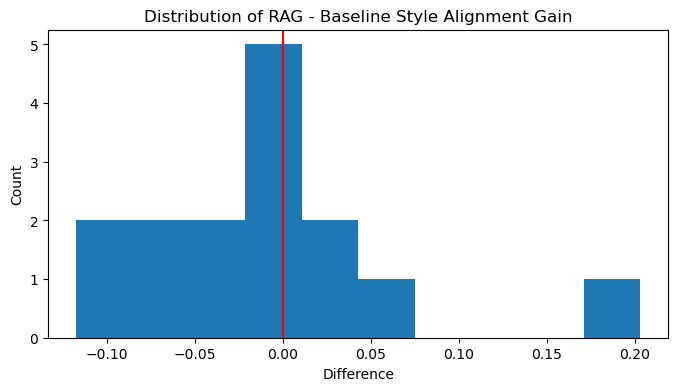

In [26]:
alignment_wins = (comparison_df["rag_alignment_gain"] > comparison_df["baseline_alignment_gain"]).mean()
print(f"RAG wins on style alignment in {alignment_wins*100:.1f}% of cases")
semantic_wins = (comparison_df["rag_semantic_preservation"] > comparison_df["baseline_semantic_preservation"]).mean()
print(f"RAG wins on semantic preservation in {semantic_wins*100:.1f}% of cases")

plt.figure(figsize=(8,4))
plt.hist(comparison_df["rag_alignment_gain"] - comparison_df["baseline_alignment_gain"], bins=10)
plt.axvline(0, color="red")
plt.title("Distribution of RAG - Baseline Style Alignment Gain")
plt.xlabel("Difference")
plt.ylabel("Count")
plt.show()


These results suggest that our RAG-based rewriting system offers clear benefits in semantic control but only modest advantages in style transformation relative to a raw LLM. The fact that RAG wins 66.7% of the time on semantic preservation indicates that grounding rewrites in real song examples helps the model maintain the original meaning more reliably, avoiding the tendency of a base LLM to over-rewrite or drift conceptually. However, the 33.3% win rate on style alignment shows that, at least in its current configuration, the RAG approach does not consistently enhance stylistic accuracy; in many cases, the raw LLM shifts the lyric toward the requested style more aggressively. This suggests a trade-off: RAG prioritizes controlled, faithful rewrites, while the baseline LLM focuses more on stylistic expressiveness. Updating the weighting between the lyric embedding and the style embedding, or adjusting the prompt to encourage bolder stylistic shifts, may help RAG better balance fidelity with stylistic strength.

## Now lets test weight_lyric:0.5 and weight_style:0.5

In [ ]:
def retrieve_style_conditioned_neighbors(
    lyric_embedding: np.ndarray,
    style_request: str,
    df: pd.DataFrame,
    k: int = 5,
    weight_lyric: float = 0.5,
    weight_style: float = 0.5,
):
    # embed style descriptor (e.g., "romantic yearning")
    style_vec = embed_lyrics(style_request)

    # weighted combination
    combined = weight_lyric * lyric_embedding + weight_style * style_vec

    # retrieve neighbors using FAISS
    raw_neighbors = retrieve_similar_songs(combined, k=k)
    return raw_neighbors


In [29]:
comparison_results = []

for orig, style in test_prompts:
    print(f"Evaluating → Lyric: '{orig}' | Style: '{style}'")
    result = compare_models_on_prompt(orig, style)
    comparison_results.append(result)

comparison_df = pd.DataFrame(comparison_results)
comparison_df


Evaluating → Lyric: 'im not cute anymore' | Style: 'romantic and yearning'
Evaluating → Lyric: 'i feel lost in the neon lights' | Style: 'moody and introspective'
Evaluating → Lyric: 'dance with me until the sunrise' | Style: 'sensual and intimate'
Evaluating → Lyric: 'i can't forget what you said' | Style: 'heartbroken and nostalgic'
Evaluating → Lyric: 'we rise again from broken dreams' | Style: 'epic and empowering'
Evaluating → Lyric: ' laughing through all the pain' | Style: 'dark and dramatic'
Evaluating → Lyric: 'i just want to run away tonight' | Style: 'rebellious and edgy'
Evaluating → Lyric: 'hold me closer than before' | Style: 'tender and loving'
Evaluating → Lyric: 'these broken streets feel cold' | Style: 'gritty and urban'
Evaluating → Lyric: 'i'm chasing shadows of your voice' | Style: 'mysterious and ethereal'
Evaluating → Lyric: 'stand tall even when you fall' | Style: 'motivational and strong'
Evaluating → Lyric: 'you left footprints on my soul' | Style: 'poetic and

,original_lyric,style_request,rag_rewrite,baseline_rewrite,rag_alignment_gain,baseline_alignment_gain,rag_semantic_preservation,baseline_semantic_preservation
0,im not cute anymore,romantic and yearning,I’m not the dream you adore,I'm no longer the dream you adore,-0.070385,-0.089247,0.434595,0.508533
1,i feel lost in the neon lights,moody and introspective,I wander lost beneath the neon glow,I'm adrift beneath the neon's glow,-0.083162,-0.066274,0.798050,0.755387
2,dance with me until the sunrise,sensual and intimate,Sway with me 'til dawn's gentle kiss,Sway with me 'til dawn's embrace,0.122059,0.051940,0.637560,0.713901
3,i can't forget what you said,heartbroken and nostalgic,"Your words linger in my mind, haunting echoes ...","Your words linger, haunting my mind",0.113894,0.157755,0.471921,0.563794
4,we rise again from broken dreams,epic and empowering,We rise anew from shattered dreams,We ascend anew from shattered visions,0.012049,0.008841,0.898765,0.589873
5,laughing through all the pain,dark and dramatic,Smiling through shadows of despair,Cackling amidst the shadows of agony,0.218860,0.210353,0.556982,0.285178
6,i just want to run away tonight,rebellious and edgy,I just wanna break free tonight,Gonna break free and vanish in the night,0.006964,0.181664,0.779950,0.480455
7,hold me closer than before,tender and loving,"Hold me near, closer than ever before",embrace me with gentle warmth,-0.035490,0.133529,0.963482,0.388001
8,these broken streets feel cold,gritty and urban,these shattered streets breathe ice,These shattered streets breathe ice,-0.046559,-0.046559,0.775809,0.775809
9,i'm chasing shadows of your voice,mysterious and ethereal,I'm tracing whispers of your echo,Whispers of your voice I pursue in shadowed re...,0.049933,0.110392,0.760733,0.734245


In [30]:
summary = comparison_df[[
    "rag_alignment_gain",
    "baseline_alignment_gain",
    "rag_semantic_preservation",
    "baseline_semantic_preservation"
]].describe()

summary


,rag_alignment_gain,baseline_alignment_gain,rag_semantic_preservation,baseline_semantic_preservation
count,15.000000,15.000000,15.000000,15.000000
mean,0.047904,0.057662,0.710073,0.614637
std,0.090394,0.093783,0.152763,0.178848
min,-0.083162,-0.089247,0.434595,0.285178
25%,-0.014263,-0.008899,0.597271,0.494494
50%,0.049933,0.051940,0.746970,0.589873
75%,0.091935,0.134215,0.789000,0.765598
max,0.218860,0.210353,0.963482,0.871734


RAG wins on style alignment in 53.3% of cases
RAG wins on semantic preservation in 60.0% of cases


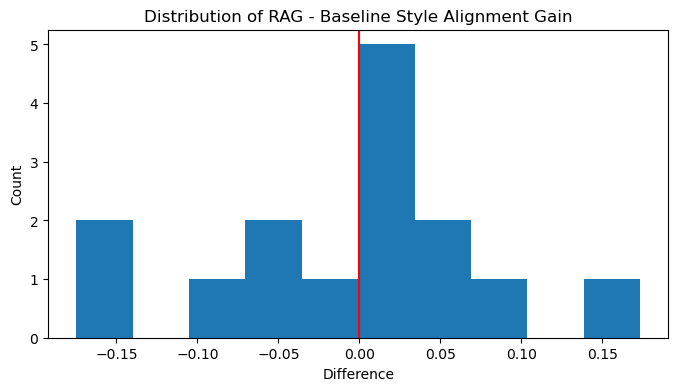

In [31]:
alignment_wins = (comparison_df["rag_alignment_gain"] > comparison_df["baseline_alignment_gain"]).mean()
print(f"RAG wins on style alignment in {alignment_wins*100:.1f}% of cases")
semantic_wins = (comparison_df["rag_semantic_preservation"] > comparison_df["baseline_semantic_preservation"]).mean()
print(f"RAG wins on semantic preservation in {semantic_wins*100:.1f}% of cases")

plt.figure(figsize=(8,4))
plt.hist(comparison_df["rag_alignment_gain"] - comparison_df["baseline_alignment_gain"], bins=10)
plt.axvline(0, color="red")
plt.title("Distribution of RAG - Baseline Style Alignment Gain")
plt.xlabel("Difference")
plt.ylabel("Count")
plt.show()


After adjusting the retrieval to weight lyric and style embeddings equally (50–50), the RAG system shows a more balanced and effective behavior: style alignment wins jump from 33.3% → 53.3%, while semantic preservation remains strong at 60%. This shift indicates that increasing the influence of the style embedding helps the system retrieve neighbors that better reflect the requested stylistic cues, enabling the rewrite to move more decisively toward the target tone. Importantly, this improvement in style alignment does not come at a major cost to meaning preservation, suggesting that the updated weighting creates a healthier equilibrium between stylistic transformation and semantic grounding. In other words, the system is now better at making the lyric sound like the requested style while still staying faithful to the original message.